# General

**Names:** Yuval Reuveni, Maya Byle



## imports

In [30]:
!export CUDA_LAUNCH_BLOCKING=1

In [31]:
import numpy as np
import torch
import torchvision
import itertools
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import random
import math
import torch.nn as nn
import seaborn as sns
import copy

from torchvision import datasets, models
from torchvision import transforms as T
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import nn, optim, cuda
from scipy.stats import norm
from skimage.filters import threshold_sauvola, threshold_otsu
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler


In [32]:
#if is_training == true, skip all training
is_training = False

#combined dataset - given code


In [33]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10


In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/My Drive/GMDL/OSR_Final_Project')

# from project_utils import CombinedDataset, eval_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data & Preprocessing

**Seed**

In [35]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.manual_seed(1)
np.random.seed(1)

**Transformations**

In [36]:
fash_mean, fash_std = 0.286, 0.353
mnist_mean, mnist_std = 0.13, 0.31
cifar_mean, cifar_std = [0.49139968, 0.48215841, 0.44653091],[0.24703223, 0.24348513, 0.26158784]

def get_transforms(is_training, augment=False, data_type="mnist"):
  mean, std = 0,0
  if data_type == "mnist":
    mean, std = mnist_mean, mnist_std
  elif data_type == "fash":
    mean, std = fash_mean, fash_std
  elif data_type == "cifar":
    mean, std = cifar_mean, cifar_std
  if is_training and augment:
    return T.Compose([
      T.ToTensor(),
      T.Grayscale(num_output_channels=1),
      T.Resize((28)),
      T.Normalize(mean, std),
      T.RandomAffine(degrees=(-20,20), translate=(0.01, 0.15), scale=(0.9, 1.1), fill=-1),
      T.RandomHorizontalFlip(p=0.5),
    ])
  else:
      return T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
        T.Grayscale(num_output_channels=1),
        T.Resize((28)),
      ])


aug_transform_mnist =get_transforms(True, augment=True, data_type="mnist")
mnist_transform_train = get_transforms(True, augment=False, data_type="mnist")
mnist_transform_test = get_transforms(False, augment=False, data_type="mnist")

fash_transform = get_transforms(False, augment=False, data_type="fash")
cifar_transform = get_transforms(False, augment=False, data_type="cifar")


**Datasets**

In [37]:
# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=mnist_transform_train)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=mnist_transform_test)
train_size = len(trainset)
train_idx = np.arange(train_size)
# validaiton split

train_subset_idx, val_subset_idx = train_test_split(train_idx, test_size=0.2,
                                              random_state=0)

# trainset_mnist, valset_mnist = torch.utils.data.random_split(train_data_mnist, lengths=[2/3, 1/3])
# Load Fashion and CIFAR test datasets
testset_fash = datasets.FashionMNIST(root="data/FashionMNIST", train=False,
                                     download=True, transform=fash_transform)

testset_cifar = datasets.CIFAR10(root="data/CIFAR10", train=False,
                                 download=True, transform=cifar_transform)

testset_OOD = torch.utils.data.ConcatDataset([testset_cifar, testset_fash])

train_subset_mnist, val_subset_mnist = train_test_split(train_subset_idx, test_size=0.2,
                                              random_state=0)

# create samplers - check if needed
train_sampler = SubsetRandomSampler(train_subset_mnist)
val_sampler = SubsetRandomSampler(val_subset_mnist)
combined_ds = CombinedDataset(mnist=testset_mnist, ood=testset_OOD)
print(len(combined_ds))
#print type of combined ds
print(type(combined_ds))
print(type(testset_mnist))

Files already downloaded and verified
30000
<class '__main__.CombinedDataset'>
<class 'torchvision.datasets.mnist.MNIST'>


**Dataloaders**

In [38]:
batch_size = 1024

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          sampler=val_sampler, num_workers=2)

test_mnist_loader = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size, shuffle=False)

test_ood_loader = torch.utils.data.DataLoader(combined_ds, batch_size=batch_size, shuffle=True)





**Plot and view the datasets**

torch.Size([1024, 1, 28, 28])


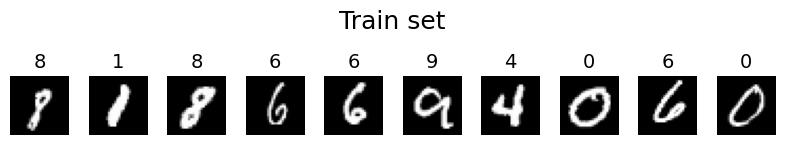

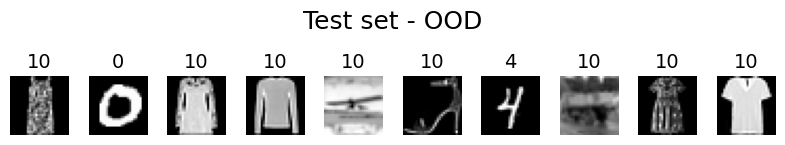

In [39]:
def plot_data_images(data_loader, title):
  dataiter = iter(data_loader)
  images, labels = next(dataiter)

  num_of_images = 10
  figure = plt.figure(figsize=(8, 1))

  for i in range(num_of_images):
      label = labels[i].cpu().numpy()
      plt.subplot(1, num_of_images, i+1)
      plt.title(label, fontsize=14)
      plt.axis('off')
      plt.imshow(images[i].numpy().squeeze(),cmap="gray")
  plt.tight_layout()
  plt.suptitle(title, fontsize=18, y=1.4)

def plot_ood_images(data_loader, title):
  dataiter = iter(data_loader)
  dataa = next(dataiter)
  images = dataa.__getitem__(0)
  labels = dataa.__getitem__(1)
  print(images.shape)
  num_of_images = 10
  figure = plt.figure(figsize=(8, 1))
  for i in range(num_of_images):
    plt.subplot(1, num_of_images, i+1)
    label = labels[i].cpu().numpy()
    plt.title(label, fontsize=14)
    plt.imshow(images[i].numpy().squeeze(),cmap="gray")
    plt.axis('off')
  plt.tight_layout()
  plt.suptitle(title, fontsize=18, y=1.4)


plot_data_images(train_loader, "Train set")
plot_ood_images(test_ood_loader, "Test set - OOD")

# Data Distributions

In [40]:
# def plot_distribution(dataset, name):
#   loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
#   data = next(iter(loader))[0].numpy()
#   data = data.reshape((data.shape[0], -1))
#   sns.histplot(data.flatten(), bins=50, kde=True)
#   plt.title(f'Distribution of pixel values in {name}')
#   plt.xlabel('Pixel Value')
#   plt.ylabel('Frequency')
#   plt.show()

# if(not is_training):
#   plot_distribution(testset_mnist, 'MNIST')
#   plot_distribution(testset_fash, 'FashionMNIST')
#   plot_distribution(testset_cifar, 'CIFAR10')

# plot the distribution of the different datasets

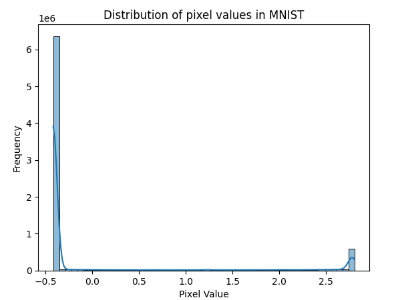

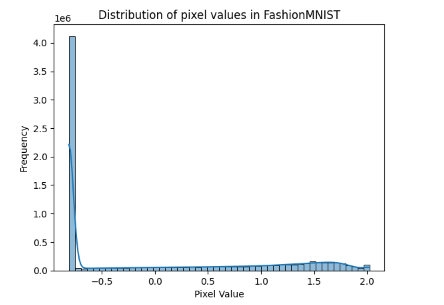

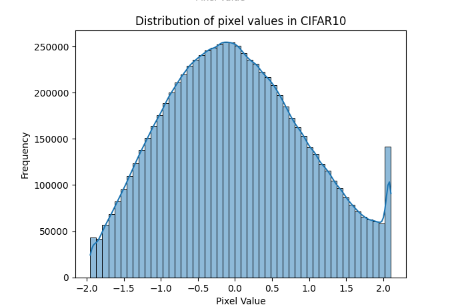

# Models

**TODO: Describe your OSR approach.**

**Baseline - CNN Archtecture**

Classify known classes using a standard classification network - convolutional neural network.

In [41]:
#baseline model class
from torchsummary import summary
class ConvNet(nn.Module):
    def __init__(self, use_dropout=False, use_dropout2d=False):
        super(ConvNet, self).__init__()
        # kernel
        # Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 5, padding='same')
        self.conv2 = nn.Conv2d(64, 32, 3, padding='same')
        # FC layers - since we use global avg pooling,
        #  input to the FC layer = #output_features of the second conv layer
        self.fc1 = nn.Linear(32, 256)
        self.fc2 = nn.Linear(256, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # adaptive_avg_pool2d with output_size=1 = simple global avg pooling
        x = self.conv2(x)
        x =  F.relu(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        # reshape
        x = x.view(-1, 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.logsoftmax(x)
        return x

input_size = (1,28,28)
baseline_model = ConvNet().to(device)

print("\n########### Baseline Model ###########")
summary(baseline_model, input_size=input_size)


########### Baseline Model ###########
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
            Conv2d-2           [-1, 32, 14, 14]          18,464
            Linear-3                  [-1, 256]           8,448
            Linear-4                   [-1, 10]           2,570
        LogSoftmax-5                   [-1, 10]               0
Total params: 31,146
Trainable params: 31,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 0.12
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


# Taining

## training func

In [42]:
def train_epoch(model, dataloader, criterion, optimizer, regularization=None):
  model.train()
  epoch_loss = 0

  for i, data in enumerate(dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      # mode to device/cuda
      inputs, labels = inputs.to(device), labels.to(device)


      # zero the parameter gradients
      optimizer.zero_grad()
      logits= model(inputs)

      # Cross-entropy loss - input=logits
      loss = criterion(logits, labels)
      # Compute the L1/L2 norm on the model's weight and add to the loss
      if regularization == "L1":
        l1_lambda = 0.0001
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        loss = loss + l1_lambda * l1_norm
      elif regularization == "L2":
        l2_lambda = 0.0001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

      loss.backward()
      optimizer.step()
      # for visualizaiton
      epoch_loss += loss.cpu().detach().item()

  return epoch_loss / len(dataloader.dataset)


## eval func

In [43]:
def eval_epoch(model, dataloader, criterion):
    model.eval()
    correct_count, all_count = 0, 0
    running_loss = 0.0
    confusion = np.zeros((10, 10))
    with torch.no_grad():
      for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred_labels = torch.max(outputs.data, 1)
        loss = criterion(outputs, pred_labels)
        running_loss += loss.item()
        pred_labels = pred_labels.detach().cpu().numpy()
        all_count += labels.shape[0]
        labels = labels.detach().cpu().numpy()
        correct_count += np.where(pred_labels == labels)[0].size
        confusion += confusion_matrix(labels, pred_labels, labels=range(10))
    return (correct_count / all_count) * 100, confusion, running_loss / len(dataloader)

In [44]:
from tqdm import tqdm
def train_baseline():
  criterion = nn.CrossEntropyLoss()
  n_epochs = 5
  train_loss_baseline = []
  val_loss_baseline = []

  print("Training:", "baseline")
  optimizer = optim.Adam(baseline_model.parameters(), lr=0.01)
  for epoch in tqdm(range(n_epochs)):
    train_loss = train_epoch(baseline_model, train_loader, criterion, optimizer)
    val_loss = eval_epoch(baseline_model, val_loader, criterion)
    train_loss_baseline.append(train_loss)
    val_loss_baseline.append(val_loss)
    torch.save(baseline_model.state_dict(),"./baseline_model")

In [45]:
if not is_training:
  train_baseline()
else:
  baseline_model.load_state_dict(torch.load("./baseline_model"))
  baseline_model.eval()

Training: baseline


100%|██████████| 5/5 [01:04<00:00, 12.93s/it]


In [46]:
def baseline_accuracy(model, data_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = correct / total
  return accuracy

**AutoEncoder**

 Use an autoencoder to reconstruct input images and use reconstruction error as a measure to detect unknown classes.

 The assumption is that the autoencoder will be good at reconstructing images that it has seen during training (e.g., MNIST images) but will struggle with images that are out of distribution (e.g., CIFAR-10 or FashionMNIST images).

In [47]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(128, 32 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(32, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2 = nn.ConvTranspose2d(16, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 32, 7, 7)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.upsample(x)
        x = F.relu(self.conv2(x))
        x = self.upsample(x)
        return x

# ML AE

**ML AutoEncoder**

Combines the classifier and autoencoder.

The model outputs both the reconstruction of the input image and the classification label.

In [48]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [49]:
class ML_Autoencoder(Autoencoder):
    def __init__(self):
        super(ML_Autoencoder, self).__init__()
        self.n_classes = 11  # K+1
        self.clf = nn.Sequential(
            nn.Linear(128, self.n_classes),
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        preds = self.clf(encoded_vector)
        return recon, preds

# train new model

In [50]:
def accuracy_calc(data_loader, model, num_labels):
    correct_count, all_count = 0, 0
    confusion = np.zeros((num_labels, num_labels), dtype=np.int32)

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            _, tags = model(images)

            # Get predictions
            _, pred_labels = torch.max(tags, 1)
            correct_count += (pred_labels == labels).sum().item()
            all_count += labels.size(0)

            # Update confusion matrix
            confusion += confusion_matrix(labels.cpu(), pred_labels.cpu(), labels=range(num_labels))

    accuracy = correct_count / all_count * 100
    return accuracy, confusion

In [51]:
#import class CombinedDataset
def evaluate_model(data_loader, model, num_labels): # MAYA
    model.eval()
    total_loss = 0.0
    correct_count, all_count = 0, 0
    confusion = np.zeros((num_labels, num_labels), dtype=np.int32)

    criterion_mse = nn.MSELoss()
    criterion_cross_entropy = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, tags = model(inputs)
            loss_mse = criterion_mse(outputs, inputs)
            loss_cross_entropy = criterion_cross_entropy(tags, labels)
            total_loss += (loss_mse + loss_cross_entropy).item()

            _, pred_labels = torch.max(tags, 1)
            correct_count += (pred_labels == labels).sum().item()
            all_count += labels.size(0)
            confusion += confusion_matrix(labels.cpu(), pred_labels.cpu(), labels=range(num_labels))

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_count / all_count * 100
    return avg_loss, accuracy, confusion

def train_model(train_loader, val_loader, epochs, model, optimizer, num_labels): # MAYA
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    model.train()
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            reconstructed, predicted_labels = model(inputs)
            loss_mse = nn.MSELoss()(reconstructed, inputs)
            loss_cross_entropy = nn.CrossEntropyLoss()(predicted_labels, labels)
            loss = (loss_mse + loss_cross_entropy)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)


        # Validation phase: combined loss and accuracy calculation
        avg_val_loss, val_accuracy, _ = evaluate_model(val_loader, model, num_labels)
        val_losses.append(avg_val_loss)
        val_acc.append(val_accuracy)

        # Calculate train accuracy separately (if needed)
        train_accuracy, _ = accuracy_calc(train_loader, model, num_labels)
        train_acc.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f} - "
              f"Train Acc: {train_accuracy:.2f}% - Validation Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_acc, val_acc


In [52]:
def plot(train, valid, title, ylabel):
    plt.figure()
    plt.title(f'{title}')
    plt.plot(np.arange(len(train)), train, label='train')
    plt.plot(np.arange(len(valid)), valid, label='validation')
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [53]:
def train_new_model():
  num_labels = 11
  epochs = 20
  input_size = 28*28
  model = ML_Autoencoder().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.0005)

  train_loss, val_loss, train_acc, val_acc = train_model(
          train_loader,
          val_loader,
          epochs,
          model,
          optimizer,
          num_labels
  )
  torch.save(model.state_dict(),"./reconstruct_model")
  plot(train_loss, val_loss, "Train & Validation Loss", "loss")
  plot(train_acc, val_acc, "MNIST Accuracy", "accuracy")
  return model


Epoch 1/20 - Train Loss: 2.1574 - Validation Loss: 1.1759 - Train Acc: 87.34% - Validation Acc: 86.82%
Epoch 2/20 - Train Loss: 0.9048 - Validation Loss: 0.7646 - Train Acc: 93.69% - Validation Acc: 93.73%
Epoch 3/20 - Train Loss: 0.6953 - Validation Loss: 0.6469 - Train Acc: 95.61% - Validation Acc: 95.53%
Epoch 4/20 - Train Loss: 0.6082 - Validation Loss: 0.5817 - Train Acc: 96.51% - Validation Acc: 96.42%
Epoch 5/20 - Train Loss: 0.5550 - Validation Loss: 0.5409 - Train Acc: 97.10% - Validation Acc: 96.96%
Epoch 6/20 - Train Loss: 0.5192 - Validation Loss: 0.5103 - Train Acc: 97.59% - Validation Acc: 97.40%
Epoch 7/20 - Train Loss: 0.4939 - Validation Loss: 0.4936 - Train Acc: 97.92% - Validation Acc: 97.73%
Epoch 8/20 - Train Loss: 0.4748 - Validation Loss: 0.4746 - Train Acc: 98.12% - Validation Acc: 97.94%
Epoch 9/20 - Train Loss: 0.4596 - Validation Loss: 0.4627 - Train Acc: 98.36% - Validation Acc: 98.06%
Epoch 10/20 - Train Loss: 0.4473 - Validation Loss: 0.4548 - Train Acc: 9

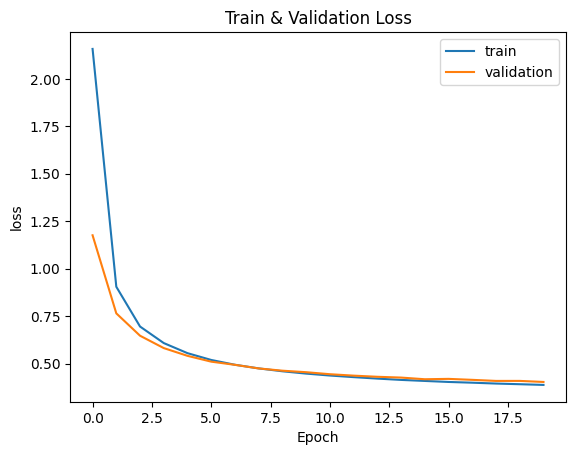

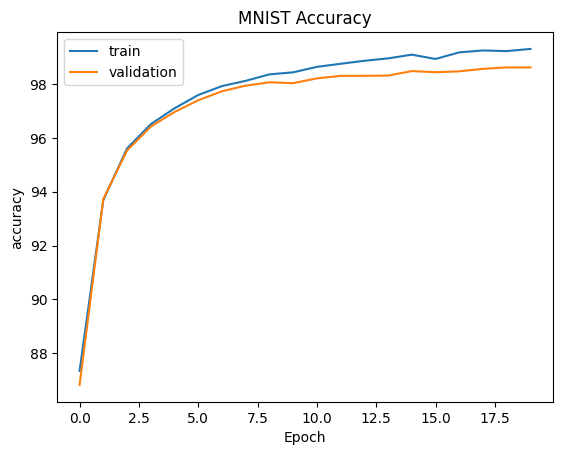

In [54]:
if not is_training:
  model = train_new_model()


# test new model

In [55]:
def make_binary(img):
    return img > threshold_otsu(img)

## compute and set thresholds for norm and difference loss

In [56]:
def measure_distance(model, dataloader):
  dist_norm = []
  dist_diffs = []
  model.eval()
  with torch.no_grad():
    for inputs, labels  in iter(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        recons, probs = model(inputs)
        recons = recons.view(-1, 28, 28).detach().cpu().numpy()
        inputs = inputs.view(-1, 28, 28).detach().cpu().numpy()
        for i in range(len(inputs)):
            original_img = inputs[i]
            recon_img = recons[i]
            BR = make_binary(recon_img)
            BO = make_binary(original_img)
            dist_norm += [np.linalg.norm(original_img - recon_img)]
            dist_diffs += [784 - np.sum(BO == BR)]
  return dist_norm, dist_diffs

### threshold for train data

In [57]:
dist_norms, dist_diffs = measure_distance(model, train_loader)
norm_threshold = np.mean(dist_norms) +  2* np.std(dist_norms)
diff_threshold = np.mean(dist_diffs) +  2*np.std(dist_diffs)
print(norm_threshold, diff_threshold)

19.341274738311768 66.4524496560253


### threshold for test ood data

## get diff between pixels

In [58]:
def get_diff_loss(input, reconstructed, model):
    model.eval()
    reconstructed = reconstructed.detach().cpu().numpy().reshape((-1, 28, 28))
    recon_binary = make_binary(reconstructed)
    original_binary = make_binary(input.detach().cpu().numpy().reshape((-1, 28, 28)))
    diffs = np.sum(recon_binary != original_binary, axis=(1, 2))
    return diffs

## get norm of loss between the original to the reconstructed image

In [59]:
def get_norm_loss(input, reconstructed, model):
    model.eval()
    loss = (input-reconstructed).detach()
    norm_loss = torch.linalg.norm(loss, dim=( 2, 3)).view((-1))
    return norm_loss

In [60]:
def map_to_classes(norm_loss, diff_loss, preds, norm_threshold, diff_threshold):
  return preds if (norm_loss < norm_threshold and diff_loss<diff_threshold )  else 10

In [61]:
from sklearn.metrics import confusion_matrix  # Import the function

def eval_model(model, data_loader):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the same device

    # Load the model state dictionary with error handling
    if is_training:
      try:
          model.load_state_dict(torch.load("./reconstruct_model")) # Try loading the model onto the specified device
      except RuntimeError as e:
          print(f"Error loading model: {e}")
    # Ensure model is in evaluation mode
    model.eval()
    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0
    confusion_mtrx = np.zeros((11, 11))
    binary_confusion = np.zeros((2, 2))
    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
      for inputs, labels in data_loader:
        inputs, labels = inputs.detach().to(device), labels.detach().to(device)
        recon, pred_labels = model(inputs)
        probas, y_pred = torch.max(pred_labels, 1)
        norm_loss = get_norm_loss(inputs, recon, model)
        diff_loss = get_diff_loss(inputs, recon, model)
        y_pred = y_pred.detach().cpu().numpy()
        for i in range(len(y_pred)):
          y_pred[i] = map_to_classes(norm_loss[i],diff_loss[i], y_pred[i], norm_threshold, diff_threshold)
        y_pred = torch.tensor(y_pred).cpu()
        labels = labels.cpu()  # Move labels to CPU
        mask_mnist = labels < 10
        mask_ood = labels == 10
        labels_mnist = labels[mask_mnist]
        labels_ood = labels[mask_ood]
        pred_mnist = y_pred[mask_mnist]
        pred_ood = y_pred[mask_ood]
        total_mnist += labels_mnist.size(0)
        total_ood += labels_ood.size(0)
        correct_mnist += (pred_mnist == labels_mnist).sum().item()
        correct_ood += (pred_ood == labels_ood).sum().item()
        binary_labels = np.asarray(list(map(lambda label: 0 if label < 10 else 1, labels.numpy())))
        binary_preds = np.asarray(list(map(lambda label: 0 if label < 10 else 1, y_pred.numpy())))
        binary_confusion += confusion_matrix(binary_labels, binary_preds, labels=[0, 1])
        confusion_mtrx += confusion_matrix(labels, y_pred, labels=range(11))
    # Calculate accuracies
    acc_mnist = correct_mnist / total_mnist if total_mnist > 0 else 0
    acc_ood = correct_ood / total_ood if total_ood > 0 else 0
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total, confusion_mtrx, binary_confusion

**MNIST baseline accuracy results**

Compute the baseline accuracy of your model on the
MNIST test set ( i.e., the baseline of your OSR model).

In [63]:
base_acc = baseline_accuracy(baseline_model, test_mnist_loader)
print(f"Baseline Accuracy: {base_acc * 100:.2f}%")

Baseline Accuracy: 89.62%


In [64]:
acc_mnist, acc_ood, acc_total, confusion, binary_confusion = eval_model(model, test_ood_loader)

In [65]:
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

MNIST Accuracy: 96.23%
OOD Accuracy: 95.20%
Total Accuracy: 95.55%


**OSR Results:**

evaluate the total accuracy on both the 10 MNIST classes and the unseen data. Plot a confusion matrix for the 11 classes (10+Un-
known).

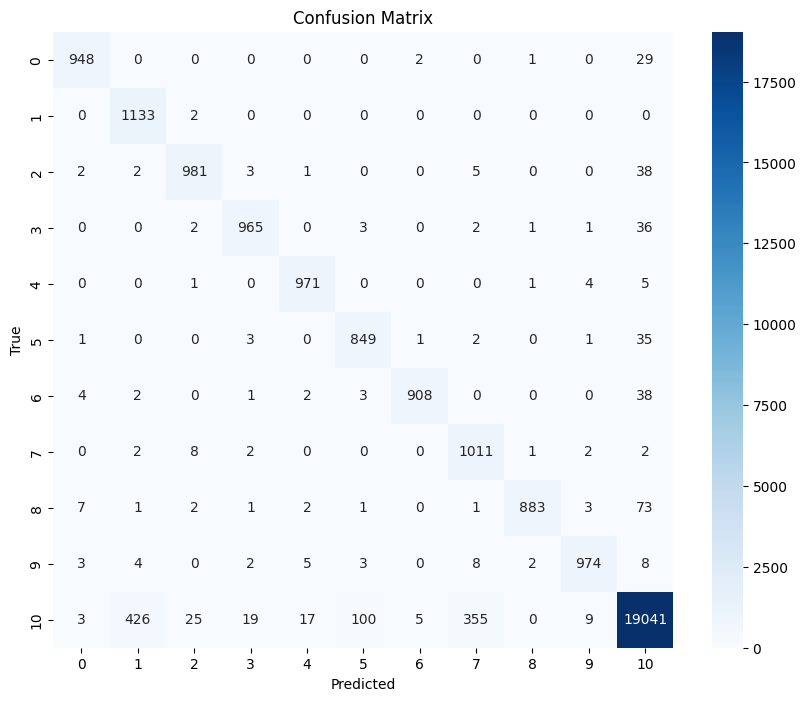

In [66]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=range(11), yticklabels=range(11))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**OOD Results**

binary classification accuracy and a Confusion matrix for
the new data. Two classes: ’Known’ and ’Unknown’. Simply map the
predictions of all 10 classes of MNIST to 0 and OSR to 1. No need for
dedicated training.

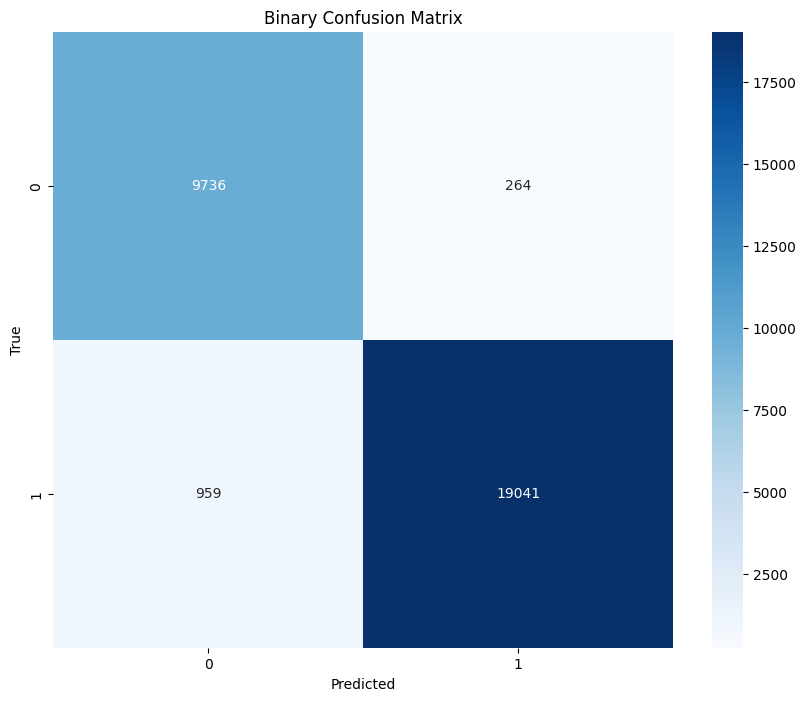

In [67]:
#plot binary confusion metrix
plt.figure(figsize=(10, 8))
sns.heatmap(binary_confusion, annot=True, fmt='g', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Binary Confusion Matrix')
plt.show()


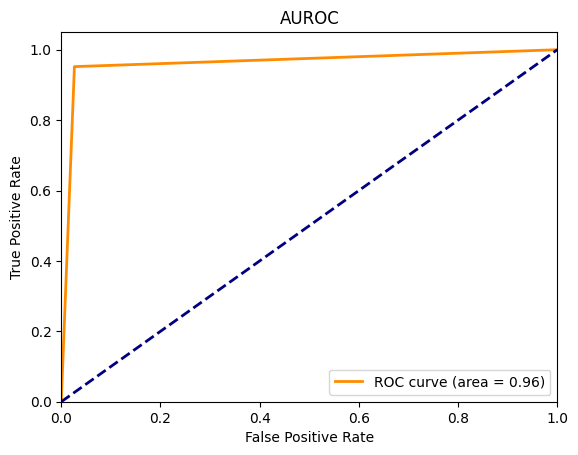

In [68]:
from sklearn.metrics import roc_curve, auc

def plot_auroc(model, data_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()

  all_labels = []
  all_scores = []

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      recon, pred_labels = model(inputs)
      probas, y_pred = torch.max(pred_labels, 1)
      norm_loss = get_norm_loss(inputs, recon, model)
      diff_loss = get_diff_loss(inputs, recon, model)
      y_pred = y_pred.detach().cpu().numpy()
      for i in range(len(y_pred)):
        y_pred[i] = map_to_classes(norm_loss[i],diff_loss[i], y_pred[i], norm_threshold, diff_threshold)

      binary_labels = np.asarray(list(map(lambda label: 0 if label < 10 else 1, labels.cpu().numpy())))
      scores = np.asarray(list(map(lambda label: 1 if label == 10 else 0, y_pred)))

      all_labels.extend(binary_labels)
      all_scores.extend(scores)

  fpr, tpr, _ = roc_curve(all_labels, all_scores)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUROC')
  plt.legend(loc="lower right")
  plt.show()

plot_auroc(model, test_ood_loader)